Active cells created from topography!
covariance:  [[[0.0004]]

 [[0.002 ]]]


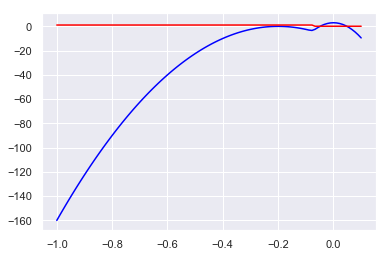

In [1]:
"""

Script of petro-inversion of gravity over TKC

Notes:
This version of the script uses data with less noises
but still invert with a higher assumed noise level.
This is equivalent to increase the chi-factor.
This has been needed in order to fit both geophysical
and petrophysical data set.
"""

# Script of petro-inversion of gravity over TKC
import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import NearestNDInterpolator
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
from pymatsolver import PardisoSolver
%matplotlib inline
matplotlib.rcParams['font.size'] = 14
import seaborn
seaborn.set()
# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

mesh = Mesh.load_mesh('../../../Forward/mesh_inverse')

# Define no-data-value
ndv = -100

# Load topography file in UBC format and find the active cells
# Import Topo
model_dir = '../../../Geology_Surfaces/'
topofile = model_dir + 'TKCtopo.dat'
topo = np.genfromtxt(topofile, skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)
print("Active cells created from topography!")

# Load data
survey = io_utils.readUBCgravityObservations(
    "../../../Forward/GRAV_noisydata.obs"
)

# Now that we have a survey we can build the linear system ...
nactv = np.int(np.sum(actv))
# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nactv)
# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv)
# Pair the survey and problem
survey.pair(prob)

# If you formed the sensitivity gravity matrix before, you can load it here
#G = np.load('../../../Forward/G_Grav_Inverse.npy')
#prob._G = G

# Define noise level
std = 0.01
eps = 0.
survey.std = std
survey.eps = eps

# **Inverse problem**

# Petro Inversion

# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
# rxLoc = survey.srcField.rxList[0].locs
# wr = PF.Magnetics.get_dist_wgt(mesh, rxLoc, actv, 3., np.min(mesh.hx)/4.)
# wr = wr**2.
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr / np.max(wr))

#Initial model
m0 = np.ones(idenMap.nP) * -1e-4

# Define Petrophysics
model_grav = mesh.readModelUBC(
    '../../../Forward/model_grav.den'
)
geomodel = mesh.readModelUBC(
    '../../../Forward/geomodel'
) 
model_grav = model_grav[model_grav != -100.]
n = 2
weights_init = np.r_[
    np.count_nonzero(geomodel[mesh.vol==mesh.vol.min()] == 0.),
    np.count_nonzero(geomodel[mesh.vol==mesh.vol.min()] == 1.)+ np.count_nonzero(geomodel[mesh.vol==mesh.vol.min()] == 2.),
]/len(geomodel[np.logical_and(mesh.vol==mesh.vol.min(),geomodel!=-100.)])
means_init = np.array([0., -0.2,]).reshape(n, 1)
cov_init = np.array(
    [[4.*1e-4],
     #[((2. * 1e-2)**2.)],
     [2e-3]]).reshape((n, 1, 1))

meshweights = copy.deepcopy(mesh)
meshweights._vol = meshweights.vol[actv]
clf = Utils.WeightedGaussianMixture(
    mesh = meshweights,
    n_components=n,
    covariance_type='full',
    reg_covar=1e-7,
    means_init=means_init,
    precisions_init=np.linalg.inv(cov_init),
    n_init=1,
    max_iter=100,
    tol=1e-3,
    init_params='random'
)
clf.fit(m0.reshape(-1, 1))
Utils.order_clusters_GM_weight(clf)
clf.weights_ = weights_init
clf.means_ = means_init
clf.covariances_ = cov_init
clf.precisions_cholesky_ = Utils._compute_precision_cholesky(
    clf.covariances_, clf.covariance_type
)
Utils.computePrecision(clf)
Utils.order_clusters_GM_weight(clf)

# wires map
wires = Maps.Wires(('m', m0.shape[0]))
# Regularization
reg = Regularization.MakeSimplePetroRegularization(
    GMmref=clf,
    GMmodel=clf,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actv,
    alpha_s=1.0, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights_list=[wr]
)
reg.mrefInSmooth = False
reg.approx_gradient = True
reg.objfcts[0].evaltype = 'approx'


# Data misfit
dmis = DataMisfit.l2_DataMisfit(survey)
# Assign flat uncertainties of 0.01mGal
wd = np.ones(len(survey.dobs)) * 0.01
dmis.W = 1 / wd


# Add directives to the inversion
# opt = Optimization.InexactGaussNewton(maxIter=30)
opt = Optimization.ProjectedGNCG(
    maxIter=30, lower=-1., upper=0., maxIterLS=20, maxIterCG=100, tolCG=1e-3
)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

Alphas = Directives.AlphasSmoothEstimate_ByEig(
    alpha0_ratio=1.,
    ninit=10, verbose=True
)
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1., ninit=10)
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5., rateWarming=1.,
    tolerance=0.1, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=1.,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)
targets = Directives.PetroTargetMisfit(verbose=True)
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True
)
petrodir = Directives.GaussianMixtureUpdateModel(
    keep_ref_fixed_in_Smooth=True,
    verbose=False,
    nu=1e8,
    kappa=1e8,
    alphadir=1e8
)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(
    invProb,
    directiveList=[
        Alphas, beta,
        petrodir, targets,
        betaIt, MrefInSmooth, update_Jacobi
    ]
)

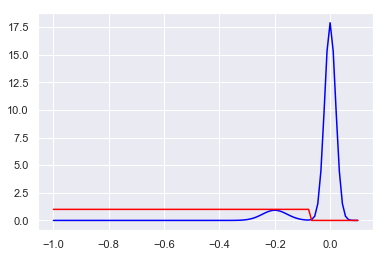

In [2]:
plt.plot(
     np.linspace(vmin, vmax, 100), np.exp(
         clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='blue'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='red'
)
plt.show()

In [3]:
# Run inversion...
mcluster = inv.run(m0)


                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Alpha scales:  [1, 1]
Alpha scales:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Alpha scales:  [0.0, 5076.640103252607, 5059.589304829066, 5458.228334887727]
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.82e+01  4.47e+06  0.00e+00  4.47e+06    6.12e+02      0              
DM:  [797959.16402625] [False] ; CL:  743782.6455982353 False ; DP:  True ; All: False
progress [797959.16402625] >< [3574452.75655989]
mref changes in  36021  places
   1  2.82e+01  7.98e+05  1.40e+04  1.19e+06    1.80e+02      0              
DM:  [246495.79848174] [False] ; CL:  321882.4

In [5]:
# Get the final model back to full space
m_petro = actvMap * mcluster
m_petro[m_petro == ndv] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


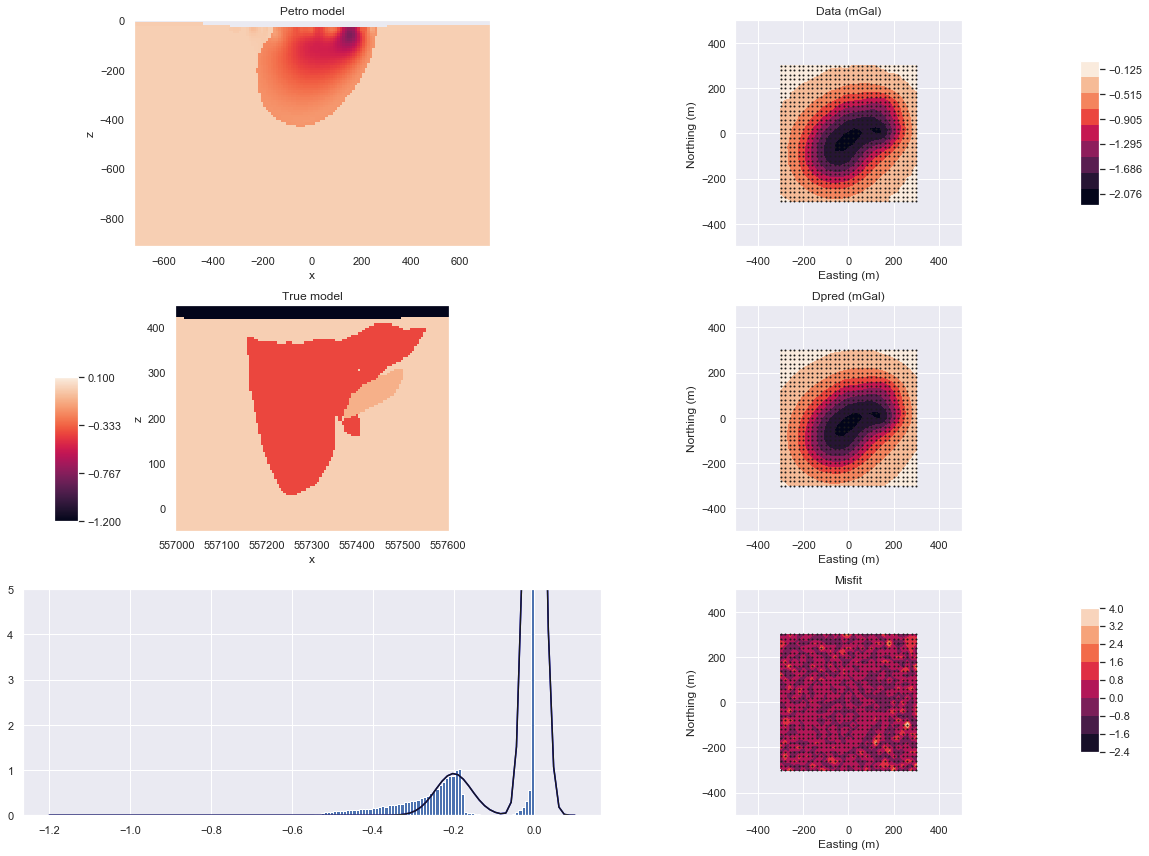

In [6]:
# Plot the recoverd models
mesh = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
npad = 10
X, Y = np.meshgrid(mesh.vectorCCx[npad:-npad:2], mesh.vectorCCy[npad:-npad:2])

vmin, vmax = -1.2, 0.1
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
ax = Utils.mkvc(ax)
mesh.plotSlice(
    m_petro, ax=ax[0], normal='Y',
    clim=np.r_[vmin, vmax]
)
ax[0].set_aspect('equal')
ax[0].set_title('Petro model')

dat_true = mesh.plotSlice(
    model_grav, ax=ax[1], normal='Y',
    clim=np.r_[vmin, vmax]
)
ax[1].set_aspect('equal')
ax[1].set_title('True model')

pos = ax[1].get_position()
cbarax = fig.add_axes(
    [pos.x0 - 0.15, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat_true[0], cax=cbarax, orientation="vertical",
    ax=ax[1], ticks=np.linspace(vmin, vmax, 4)
)
mcluster = m_petro[~np.isnan(m_petro)]
ax[2].hist(mcluster, bins=100, normed=True)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    ),
    color='blue'
)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        reg.objfcts[0].GMmodel.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    ),
    color='k'
)
ax[2].set_ylim([0., 5.])

gmin, gmax = np.min(survey.dobs), np.max(survey.dobs)
d2D = survey.dobs.reshape(X.shape)
dat = ax[3].contourf(X, Y, d2D, vmin=gmin, vmax=gmax)
ax[3].set_aspect('equal')
ax[3].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[3].set_xlabel("Easting (m)")
ax[3].set_ylabel("Northing (m)")
ax[3].set_title("Data (mGal)")
ax[3].set_xlim(-500, 500)
ax[3].set_ylim(-500, 500)

pos = ax[3].get_position()
cbarax = fig.add_axes(
    [pos.x0 + 0.3, pos.y0 + 0.1,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat, cax=cbarax, orientation="vertical",
    ax=ax[3], ticks=np.linspace(gmin, gmax, 6)
)

dpred = prob.fields(mcluster)
d2D = dpred.reshape(X.shape)
dat = ax[4].contourf(X, Y, d2D, vmin=gmin, vmax=gmax)
ax[4].set_aspect('equal')
ax[4].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[4].set_xlabel("Easting (m)")
ax[4].set_ylabel("Northing (m)")
ax[4].set_title("Dpred (mGal)")
ax[4].set_xlim(-500, 500)
ax[4].set_ylim(-500, 500)

# pos = ax[4].get_position()
# cbarax = fig.add_axes(
#     [pos.x0+0.3 , pos.y0,  pos.width*0.1, pos.height*0.75]
# )  # the parameters are the specified position you set
# cb = fig.colorbar(
#     dat,cax=cbarax, orientation="vertical",
#     ax=ax[4],ticks=np.linspace(gmin,gmax, 6)
# )

misfit = (survey.dobs - dpred) / std
d2D = misfit.reshape(X.shape)
dat = ax[5].contourf(X, Y, d2D)
ax[5].set_aspect('equal')
ax[5].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[5].set_xlabel("Easting (m)")
ax[5].set_ylabel("Northing (m)")
ax[5].set_title("Misfit")
ax[5].set_xlim(-500, 500)
ax[5].set_ylim(-500, 500)

pos = ax[5].get_position()
cbarax = fig.add_axes(
    [pos.x0 + 0.3, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat, cax=cbarax, orientation="vertical",
    ax=ax[5],
)
plt.tight_layout()
#fig.savefig(
#    'PF_AllUnits_with_jacobi_less_noise_no_Inversion_crime.png',
#    dpi=150
#)
plt.show()
